Client 1 Features: ['age', 'marital', 'default', 'housing', 'contact', 'month', 'pdays', 'poutcome']
Client 2 Features: ['job', 'education', 'balance', 'loan', 'day', 'campaign', 'previous']
Client 1 Features: ['age', 'marital', 'default', 'housing', 'contact', 'month', 'pdays', 'poutcome']
Client 2 Features: ['job', 'education', 'balance', 'loan', 'day', 'campaign', 'previous']
Train Partition 1 Columns:
Index(['age', 'default', 'housing', 'pdays', 'deposit', 'marital_married',
       'marital_single', 'contact_telephone', 'contact_unknown', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown'],
      dtype='object')
Train Partition 2 Columns:
Index(['balance', 'loan', 'day', 'campaign', 'previous', 'deposit',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_sel

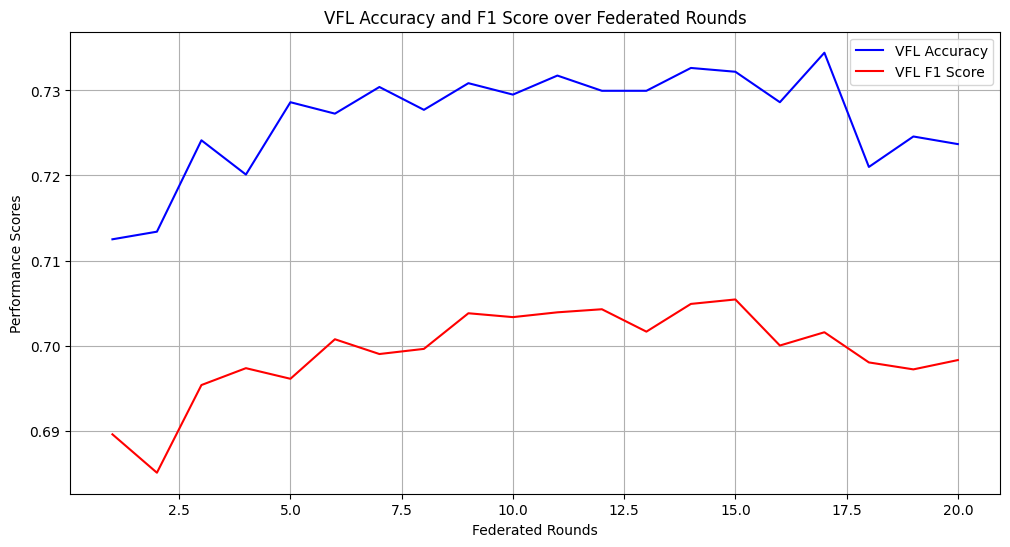

In [13]:

# Bank Marketing

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import random

seed = 53
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Dataset loading....
df = pd.read_csv("/content/bank.csv")

# Data preprocessing steps
def preprocess_data(df):
    # Irrelevant column "duration" dropped
    df = df.drop(columns=['duration'])

    # We need to encode binary categorical variables
    label_encoders = {}
    binary_columns = ['default', 'housing', 'loan', 'deposit']
    for column in binary_columns:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le

    return df, label_encoders

df, label_encoders = preprocess_data(df)

# Vertically partition of the data "before" one-hot encoding :)
def vertical_partition(df, num_clients):
    partitions = [[] for _ in range(num_clients)]
    num_features = df.shape[1]

    for i, feature in enumerate(df.columns):
        participant = i % num_clients
        partitions[participant].append(feature)

    for i, partition in enumerate(partitions):
        print(f"Client {i + 1} Features: {partition}")

    partitioned_dfs = [df[features] for features in partitions]
    return partitioned_dfs

# Tarin-Test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
y_train = train_df['deposit'].values
y_test = test_df['deposit'].values

train_partitions = vertical_partition(train_df.drop(columns=['deposit']), 2)
test_partitions = vertical_partition(test_df.drop(columns=['deposit']), 2)

for i in range(len(train_partitions)):
    train_partitions[i]['deposit'] = y_train
    test_partitions[i]['deposit'] = y_test

# And now we apply one-hot encoding after vertical partitioning to ensure that each participant had a complete set of encoded features corresponding to their own assigned raw features from vertical split only
for i in range(len(train_partitions)):
    train_partitions[i] = pd.get_dummies(train_partitions[i], drop_first=True)
    test_partitions[i] = pd.get_dummies(test_partitions[i], drop_first=True)

# We have to ensure first that both training and testing partitions have the same columns after one-hot encoding
for i in range(len(train_partitions)):
    train_partitions[i], test_partitions[i] = train_partitions[i].align(test_partitions[i], join='left', axis=1, fill_value=0)

# Partitions and their columns for both test and train
for i, partition in enumerate(train_partitions):
    print(f"Train Partition {i + 1} Columns:")
    print(partition.columns)

for i, partition in enumerate(test_partitions):
    print(f"Test Partition {i + 1} Columns:")
    print(partition.columns)

# Normalization of the features
scaler = StandardScaler()
for i in range(len(train_partitions)):
    feature_columns = train_partitions[i].columns.difference(['deposit'])
    train_partitions[i][feature_columns] = scaler.fit_transform(train_partitions[i][feature_columns])
    test_partitions[i][feature_columns] = scaler.transform(test_partitions[i][feature_columns])

# Partitions to PyTorch datasets conversion
def create_tensor_datasets(partitions):
    tensor_partitions = []
    for partition in partitions:
        partition = partition.apply(pd.to_numeric, errors='coerce')
        partition = partition.fillna(0)

        for col in partition.select_dtypes(include=['bool']).columns:
            partition[col] = partition[col].astype(int)

        features = partition.drop(columns=["deposit"]).values
        labels = partition["deposit"].values.astype(np.int64)

        tensor_partition = TensorDataset(torch.tensor(features, dtype=torch.float32), torch.tensor(labels, dtype=torch.long))
        tensor_partitions.append(tensor_partition)
    return tensor_partitions

train_tensor_partitions = create_tensor_datasets(train_partitions)
test_tensor_partitions = create_tensor_datasets(test_partitions)

# GlobalModel class
class GlobalModel(nn.Module):
    def __init__(self, input_sizes, hidden_sizes, output_size):
        super(GlobalModel, self).__init__()
        self.segments = nn.ModuleList()
        for input_size, hidden_size in zip(input_sizes, hidden_sizes):
            layers = [nn.Linear(input_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, output_size)]
            layers.append(nn.Dropout(p=0.5))
            self.segments.append(nn.Sequential(*layers))

    def forward(self, x, active_segments):
        segment_outputs = []
        start_index = 0
        for i, segment in enumerate(self.segments):
            end_index = start_index + input_sizes[i]
            if i in active_segments:
                segment_input = x[:, start_index:end_index]  # We extract the segment of the input corresponding to the active participant's features only
                segment_output = segment(segment_input)
                segment_outputs.append(segment_output)
            else:
                segment_outputs.append(torch.zeros(x.size(0), output_size, device=x.device)) # Non-active segments are appended with zero
            start_index = end_index
        combined_output = torch.mean(torch.stack(segment_outputs), dim=0)
        return combined_output

# Class weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = compute_class_weight(class_weight='balanced', classes=[0, 1], y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Training function
def train(model, device, train_loader, optimizer, epoch, input_sizes, participant_id):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(data.size(0), -1)  # Segments not corresponding to the active participant are replaced with zero tensors
        padded_data = torch.zeros(data.size(0), sum(input_sizes)).to(device)
        start_index = sum(input_sizes[:participant_id])
        end_index = start_index + input_sizes[participant_id]
        padded_data[:, start_index:end_index] = data
        optimizer.zero_grad()
        output = model(padded_data, active_segments=[participant_id])
        loss = nn.CrossEntropyLoss(weight=class_weights)(output, target)
        loss.backward()
        optimizer.step()

# Selective gradient exchange function
def selective_exchange_gradients(models, input_sizes, hidden_sizes):
    num_models = len(models)
    param_indices = [0]
    cumulative_index = 0
    for i in range(len(hidden_sizes)):
        cumulative_index += (input_sizes[i] * hidden_sizes[i]) + hidden_sizes[i]
        param_indices.append(cumulative_index)

    for seg in range(len(hidden_sizes)):
        start = param_indices[seg]
        end = param_indices[seg + 1]
        for param_idx in range(start, end):
            grads = []
            for model in models:
                model_params = list(model.parameters())
                if param_idx < len(model_params) and model_params[param_idx].grad is not None:
                    grads.append(model_params[param_idx].grad)
            if grads:
                avg_grad = torch.stack(grads).mean(dim=0)
                for model in models:
                    model_params = list(model.parameters())
                    if param_idx < len(model_params):
                        model_params[param_idx].grad = avg_grad.clone()

# Evaluation function to calculate accuracy and F1 score
def evaluate(models, device, test_loaders, input_sizes):
    for model in models:
        model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch_data in zip(*test_loaders):
            data_list = []
            target_list = []
            for participant_id, (data, target) in enumerate(batch_data):
                data_list.append(data)
                target_list.append(target)

            target = target_list[0].to(device)
            for t in target_list:
                assert torch.equal(t, target), "Targets are not consistent across participants"

            data_combined = torch.cat(data_list, dim=1).to(device)

            padded_data = torch.zeros(data_combined.size(0), sum(input_sizes)).to(device)
            start_index = 0
            for participant_id in range(len(input_sizes)):
                end_index = start_index + input_sizes[participant_id]
                if end_index <= data_combined.size(1):
                    padded_data[:, start_index:end_index] = data_combined[:, start_index:end_index]
                else:
                    adjusted_end_index = data_combined.size(1)
                    padded_data[:, start_index:adjusted_end_index] = data_combined[:, start_index:adjusted_end_index]
                start_index = end_index

            outputs = torch.zeros(data_combined.size(0), 2, device=device)
            for model in models:
                output = model(padded_data, active_segments=list(range(len(model.segments))))
                outputs += output
            outputs /= len(models)

            pred = outputs.argmax(dim=1, keepdim=True)
            all_preds.extend(pred.view(-1).cpu().numpy())
            all_targets.extend(target.view(-1).cpu().numpy())

    accuracy = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)
    print(f'Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')
    return accuracy, f1

# Input sizes after one-hot encoding
input_sizes = [partition.shape[1] - 1 for partition in train_partitions]  # minus 1 for 'deposit' column
print("Input sizes:", input_sizes)
hidden_sizes = [10] * 2
output_size = 2  # binary classification

models = [GlobalModel(input_sizes, hidden_sizes, output_size).to(device) for _ in range(2)]
optimizers = [optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) for model in models]

federated_rounds = 20  # Number of federated rounds
epochs_per_round = 10

# Lists to store accuracy and F1 score after each round
vfl_accuracies = []
vfl_f1_scores = []

for federated_round in range(federated_rounds):
    print(f"Federated Round {federated_round + 1}/{federated_rounds}")
    for participant_id in range(2):
        print(f"  Training Participant {participant_id + 1}")
        train_loader = DataLoader(train_tensor_partitions[participant_id], batch_size=64, shuffle=True)
        for epoch in range(1, epochs_per_round + 1):
            train(models[participant_id], device, train_loader, optimizers[participant_id], epoch, input_sizes, participant_id)

    selective_exchange_gradients(models, input_sizes, hidden_sizes)

    # Accuracy and F1 score after each round
    test_loaders = [DataLoader(test_tensor_partitions[i], batch_size=32, shuffle=False) for i in range(2)]
    accuracy, f1 = evaluate(models, device, test_loaders, input_sizes)
    vfl_accuracies.append(accuracy)
    vfl_f1_scores.append(f1)

# Plotting the accuracy and F1 score over federated rounds
plt.figure(figsize=(12, 6))
plt.plot(range(1, federated_rounds + 1), vfl_accuracies, label='VFL Accuracy', color='blue')
plt.plot(range(1, federated_rounds + 1), vfl_f1_scores, label='VFL F1 Score', color='red')
plt.xlabel('Federated Rounds')
plt.ylabel('Performance Scores')
plt.title('VFL Accuracy and F1 Score over Federated Rounds')
plt.legend(loc='best')
plt.grid(True)
plt.show()
